<a href="https://colab.research.google.com/github/samriddh202/IIIT_Internship_Code/blob/main/Image_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import keras
import tqdm
from sklearn.model_selection import train_test_split
import tarfile
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
import cv2
import os
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:

ATTRS_NAME = "/content/drive/My Drive/Dataset/Face_generator/lfw_attributes.txt"

IMAGES_NAME = "/content/drive/My Drive/Dataset/Face_generator/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "/content/drive/My Drive/Dataset/Face_generator/lfw.tgz"


In [ ]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [ ]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
X = X.astype('float32') / 255.0 - 0.5
type(X)

numpy.ndarray

In [ ]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

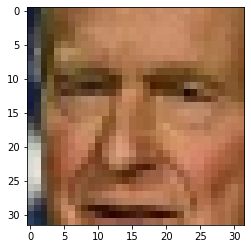

In [ ]:
show_image(X[9])

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [ ]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [ ]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 100)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               307300    
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         310272    
Total params: 617,572
Trainable params: 617,572
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test])

Epoch 1/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 2/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 3/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 4/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 5/25
129/129 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 6/25
129/129 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 7/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 8/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 9/25
129/129 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 10/25
129/129 [==============================] - 

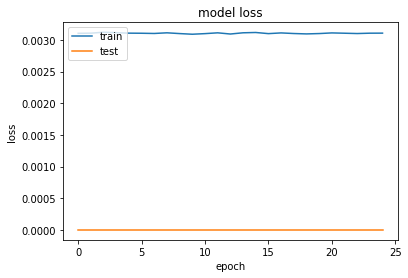

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

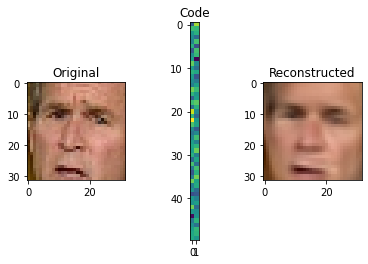

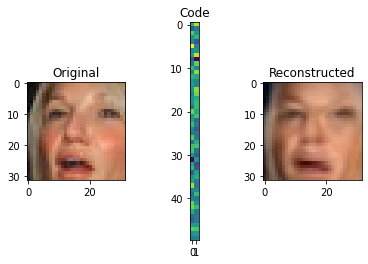

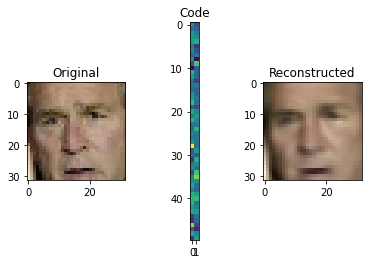

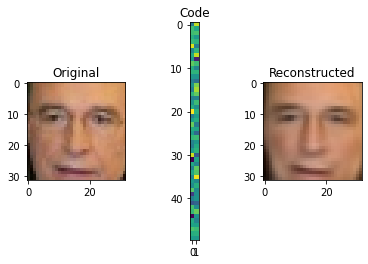

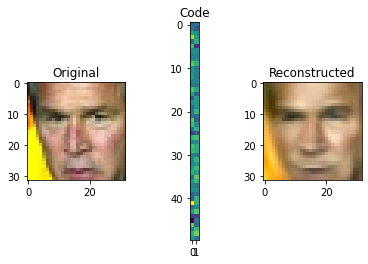

In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)